In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optimizers
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import datasets
import torchvision.transforms as transforms
from callbacks import EarlyStopping

In [8]:
'''
0. モデルの定義
'''
class DNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.l1 = nn.Linear(input_dim, hidden_dim)
        self.b1=nn.BatchNorm1d(hidden_dim)
        self.a1 = nn.ReLU()
        self.d1 = nn.Dropout(0.5)
        self.l2 = nn.Linear(hidden_dim, hidden_dim)
        self.b2=nn.BatchNorm1d(hidden_dim)
        self.a2 = nn.ReLU()
        self.d2 = nn.Dropout(0.5)
        self.l3 = nn.Linear(hidden_dim, hidden_dim)
        self.b3=nn.BatchNorm1d(hidden_dim)
        self.a3 = nn.ReLU()
        self.d3 = nn.Dropout(0.5)
        self.l4 = nn.Linear(hidden_dim, output_dim)

        self.layers = [self.l1, self.b1, self.a1, self.d1,self.l2, self.b2, self.a2, self.d2,
                       self.l3, self.b3, self.a3, self.d3,self.l4]
        
        for layer in self.layers:
            if type(layer)==nn.Linear:
                nn.init.kaiming_normal_(layer.weight) # relu 
                #nn.init.xavier_normal_(layer.weight) # sigmoid

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [9]:
np.random.seed(123)
torch.manual_seed(123)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

'''
1. データの準備
'''
root = os.path.join('~', '.torch', 'mnist')
transform = transforms.Compose([transforms.ToTensor(),
                                lambda x: x.view(-1)])
mnist_train = datasets.MNIST(root=root,
                             download=True,
                             train=True,
                             transform=transform)
mnist_test = datasets.MNIST(root=root,
                            download=True,
                            train=False,
                            transform=transform)

n_samples = len(mnist_train)
n_train = int(n_samples * 0.8)
n_val = n_samples - n_train

mnist_train, mnist_val = random_split(mnist_train, [n_train, n_val])

train_dataloader = DataLoader(mnist_train,batch_size=100,shuffle=True)
val_dataloader = DataLoader(mnist_val,batch_size=100,shuffle=False)
test_dataloader = DataLoader(mnist_test,batch_size=100,shuffle=False)

'''
2. モデルの構築
'''
model = DNN(784, 200, 10).to(device)

In [10]:
'''
3. モデルの学習
'''
criterion = nn.CrossEntropyLoss()
#optimizer = optimizers.SGD(model.parameters(), lr=0.01)
#optimizer=optimizers.SGD(model.parameters(),lr=0.01,momentum=0.9)
#optimizer=optimizers.SGD(model.parameters(),lr=0.01,momentum=0.9,nesterov=True)
#optimizer=optimizers.Adagrad(model.parameters(),lr=0.01)
#optimizer=optimizers.RMSprop(model.parameters(),lr=0.001,alpha=0.99)
#optimzier=optimizers.Adadelta(model.parameters(),rho=0.95)
#optimizer=optimizers.Adam(model.parameters(),lr=0.001,betas=(0.9,0.999))
optimizer=optimizers.Adam(model.parameters(),lr=0.001,betas=(0.9,0.999),amsgrad=True)

def compute_loss(t, y):
    return criterion(y, t)

def train_step(x, t):
    model.train()
    preds = model(x)
    loss = compute_loss(t, preds)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss, preds

def val_step(x, t):
    model.eval()
    preds = model(x)
    loss = criterion(preds, t)

    return loss, preds

epochs = 1000
hist = {'val_loss': [], 'val_accuracy': []}
es=EarlyStopping(patience=5,verbose=1)

for epoch in range(epochs):
    train_loss = 0.
    train_acc = 0.
    val_loss = 0.
    val_acc = 0.

    for (x, t) in train_dataloader:
        x, t = x.to(device), t.to(device)
        loss, preds = train_step(x, t)
        train_loss += loss.item()
        train_acc += accuracy_score(t.tolist(),preds.argmax(dim=-1).tolist())

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    for (x, t) in val_dataloader:
        x, t = x.to(device), t.to(device)
        loss, preds = val_step(x, t)
        val_loss += loss.item()
        val_acc += accuracy_score(t.tolist(),preds.argmax(dim=-1).tolist())

    val_loss /= len(val_dataloader)
    val_acc /= len(val_dataloader)

    hist['val_loss'].append(val_loss)
    hist['val_accuracy'].append(val_acc)

    print('epoch: {}, loss: {:.3}, acc: {:.3f}, val_loss: {:.3}, val_acc: {:.3f}'.format(epoch+1,train_loss,train_acc,val_loss,val_acc))
    if es(val_loss):
        break

epoch: 1, loss: 0.815, acc: 0.739, val_loss: 0.235, val_acc: 0.928
epoch: 2, loss: 0.385, acc: 0.885, val_loss: 0.18, val_acc: 0.945
epoch: 3, loss: 0.315, acc: 0.906, val_loss: 0.15, val_acc: 0.954
epoch: 4, loss: 0.268, acc: 0.921, val_loss: 0.134, val_acc: 0.960
epoch: 5, loss: 0.237, acc: 0.929, val_loss: 0.125, val_acc: 0.962
epoch: 6, loss: 0.209, acc: 0.938, val_loss: 0.114, val_acc: 0.965
epoch: 7, loss: 0.198, acc: 0.943, val_loss: 0.106, val_acc: 0.966
epoch: 8, loss: 0.186, acc: 0.945, val_loss: 0.0996, val_acc: 0.968
epoch: 9, loss: 0.174, acc: 0.949, val_loss: 0.0953, val_acc: 0.969
epoch: 10, loss: 0.166, acc: 0.951, val_loss: 0.0902, val_acc: 0.971
epoch: 11, loss: 0.156, acc: 0.953, val_loss: 0.0896, val_acc: 0.972
epoch: 12, loss: 0.151, acc: 0.956, val_loss: 0.085, val_acc: 0.973
epoch: 13, loss: 0.142, acc: 0.958, val_loss: 0.0828, val_acc: 0.973
epoch: 14, loss: 0.136, acc: 0.959, val_loss: 0.0809, val_acc: 0.974
epoch: 15, loss: 0.132, acc: 0.961, val_loss: 0.0785,

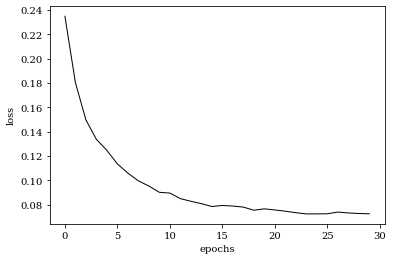

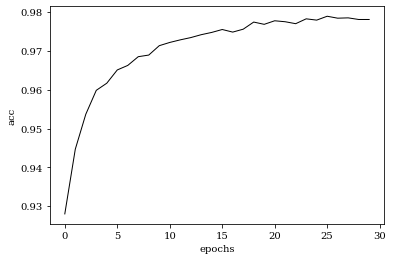

test_loss: 0.068, test_acc: 0.980


In [11]:
'''
4. モデルの評価
'''
# 検証データの誤差の可視化
val_loss = hist['val_loss']

fig = plt.figure()
plt.rc('font', family='serif')
plt.plot(range(len(val_loss)), val_loss,color='black', linewidth=1)
plt.xlabel('epochs')
plt.ylabel('loss')
# plt.savefig('output.jpg')
plt.show()

# 正解率の可視化
val_acc = hist['val_accuracy']

fig = plt.figure()
plt.rc('font', family='serif')
plt.plot(range(len(val_acc)), val_acc,color='black', linewidth=1)
plt.xlabel('epochs')
plt.ylabel('acc')
plt.savefig('output_acc.jpg')
plt.show()

# テストデータの評価
def test_step(x, t):
    return val_step(x, t)

test_loss = 0.
test_acc = 0.

for (x, t) in test_dataloader:
    x, t = x.to(device), t.to(device)
    loss, preds = test_step(x, t)
    test_loss += loss.item()
    test_acc += accuracy_score(t.tolist(),preds.argmax(dim=-1).tolist())

test_loss /= len(test_dataloader)
test_acc /= len(test_dataloader)
print('test_loss: {:.3f}, test_acc: {:.3f}'.format(test_loss,test_acc))